In [200]:
import sys
sys.path.append("../src/")

import nussl
from nussl.datasets import transforms as nussl_tfm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

import models

In [2]:
# generate dataset
source1 = nussl.AudioSignal('../sounds/phone/cellphone_ringing.wav')
source2 = nussl.AudioSignal('../sounds/siren/siren.wav')

In [3]:
source1.embed_audio(display=False)

In [4]:
source2.embed_audio(display=False)

In [213]:
# preprocess sources
source2.to_mono(overwrite=True)
source1.truncate_seconds(source2.signal_duration)
print(source1)
print(source2)
mix = source1 + source2
print(mix)
mix.embed_audio(display=False)

AudioSignal (unlabeled): 4.315 sec @ ../sounds/phone/cellphone_ringing.wav, 44100 Hz, 1 ch.
AudioSignal (unlabeled): 4.315 sec @ ../sounds/siren/siren.wav, 44100 Hz, 1 ch.
AudioSignal (unlabeled): 4.315 sec @ ../sounds/phone/cellphone_ringing.wav, 44100 Hz, 1 ch.


In [233]:
# rnn separator
rnn_config = {
    'bidirectional': True,
    'dropout': 0.3,
    'filter_length': 256,
    'hidden_size': 50,
    'hop_length': 64,
    'mask_activation': ['softmax'],
    'mask_complex': False,
    'mix_key': 'mix_audio',
    'normalization_class': 'BatchNorm',
    'num_audio_channels': 1,
    'num_filters': 256,
    'num_layers': 1,
    'num_sources': 2,
    'rnn_type': 'lstm',
    'window_type': 'sqrt_hann',
}

rnn_config = nussl.ml.networks.builders.build_recurrent_end_to_end(**rnn_config)

rnn = models.RnnSeparator(rnn_config)

/home/tnarg/anaconda3/envs/otoworld/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [234]:
class PreTrainDataset(Dataset):
    def __init__(self):
        # load the two sources
        source1 = nussl.AudioSignal('../sounds/phone/cellphone_ringing.wav')
        source2 = nussl.AudioSignal('../sounds/siren/siren.wav')
        
        # preprocess 
        source2.to_mono(overwrite=True)
        source1.truncate_seconds(source2.signal_duration)
        mix = source1 + source2
        sample = {'mix': mix, 'sources': {'source1': source1, 'source2': source2}}
        
        # transform
        self.transform = nussl_tfm.Compose([
            nussl_tfm.GetAudio(),
            nussl_tfm.ToSeparationModel()
        ])
        
        sample = self.transform(sample)
        
        # train on many of the same examples
        self.items = [sample] * 500
    
    def __getitem__(self, index):
        item = self.items[index]
        return item
    
    def __len__(self):
        return len(self.items)

In [235]:
dataset = PreTrainDataset()

In [236]:
dataloader = DataLoader(dataset, batch_size=10)

In [237]:
loss_fn = nussl.ml.train.loss.SISDRLoss()
optimizer = optim.Adam(rnn.parameters(), lr=1e-3)

In [238]:
losses = []
for i, data in enumerate(dataloader):    
    output = rnn(data)  # {'audio': , 'mask': }
    
    # preds vs. ground truth
    loss = loss_fn(output['audio'], data['source_audio'])
    print(loss)
    losses.append(loss)
    
    # backprop
    loss.backward()
    optimizer.step()

tensor(-0.2926, grad_fn=<NegBackward>)
tensor(-2.6156, grad_fn=<NegBackward>)
tensor(-4.4151, grad_fn=<NegBackward>)
tensor(-5.7292, grad_fn=<NegBackward>)
tensor(-6.6699, grad_fn=<NegBackward>)
tensor(-7.3658, grad_fn=<NegBackward>)
tensor(-7.9328, grad_fn=<NegBackward>)
tensor(-8.4073, grad_fn=<NegBackward>)
tensor(-8.8153, grad_fn=<NegBackward>)
tensor(-9.1959, grad_fn=<NegBackward>)
tensor(-9.5639, grad_fn=<NegBackward>)
tensor(-9.9137, grad_fn=<NegBackward>)
tensor(-10.2115, grad_fn=<NegBackward>)
tensor(-10.4746, grad_fn=<NegBackward>)
tensor(-10.7095, grad_fn=<NegBackward>)
tensor(-10.9244, grad_fn=<NegBackward>)
tensor(-11.1148, grad_fn=<NegBackward>)
tensor(-11.2716, grad_fn=<NegBackward>)
tensor(-11.3897, grad_fn=<NegBackward>)
tensor(-11.4915, grad_fn=<NegBackward>)
tensor(-11.5828, grad_fn=<NegBackward>)
tensor(-11.6512, grad_fn=<NegBackward>)
tensor(-11.6984, grad_fn=<NegBackward>)
tensor(-11.7300, grad_fn=<NegBackward>)
tensor(-11.7488, grad_fn=<NegBackward>)
tensor(-11.7

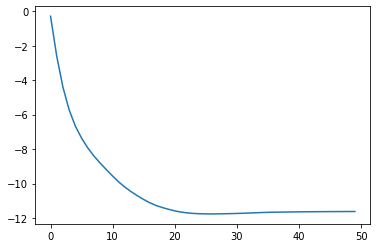

In [240]:
plt.plot(losses)

In [241]:
save_path = '../models/pretrained.pth'
torch.save(rnn.state_dict(), save_path)

In [242]:
rnn = models.RnnSeparator(rnn_config)
rnn.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [243]:
# test
pred = rnn(data)

pred['audio'].shape

torch.Size([10, 1, 190308, 2])

In [265]:
output

{'audio': tensor([[[[ 0.2072,  0.0320],
           [ 0.0822,  0.0655],
           [-0.0331,  0.0614],
           ...,
           [-0.0742, -0.1062],
           [-0.1741, -0.0883],
           [-0.2947, -0.0284]]],
 
 
         [[[ 0.2072,  0.0320],
           [ 0.0822,  0.0655],
           [-0.0331,  0.0614],
           ...,
           [-0.0742, -0.1062],
           [-0.1741, -0.0883],
           [-0.2947, -0.0284]]],
 
 
         [[[ 0.2072,  0.0320],
           [ 0.0822,  0.0655],
           [-0.0331,  0.0614],
           ...,
           [-0.0742, -0.1062],
           [-0.1741, -0.0883],
           [-0.2947, -0.0284]]],
 
 
         ...,
 
 
         [[[ 0.2072,  0.0320],
           [ 0.0822,  0.0655],
           [-0.0331,  0.0614],
           ...,
           [-0.0742, -0.1062],
           [-0.1741, -0.0883],
           [-0.2947, -0.0284]]],
 
 
         [[[ 0.2072,  0.0320],
           [ 0.0822,  0.0655],
           [-0.0331,  0.0614],
           ...,
           [-0.0742, -0.1062],
 

In [244]:
pred_source1 = pred['audio'][-1, 0, :, 0]
pred_source2 = pred['audio'][-1, 0, :, 1]

In [245]:
truth_source1 = data['source_audio'][-1, 0, :, 0]
truth_source2 = data['source_audio'][-1, 0, :, 1]

In [268]:
pred_source1 = nussl.AudioSignal(audio_data_array=output['audio'][0, ..., 0].detach().numpy(), sample_rate=8000)
pred_source1.audio_data.shape

(1, 190308)

### Evaluate

In [246]:
def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='linear', db_cutoff=-80, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)

In [247]:
# load saved model
rnn = models.RnnSeparator(rnn_config)
model_dict = torch.load(save_path)
rnn.load_state_dict(model_dict)

separator = nussl.separation.deep.DeepAudioEstimation(mix, model_path=None)
separator.model = rnn

print(separator.model)

separator.transform = nussl_tfm.Compose([
    nussl_tfm.GetAudio(),
    nussl_tfm.ToSeparationModel()
])

separator.device = 'cpu'

print(mix.stft_params)
separator.metadata = {
    'sample_rate': 8000,
    'stft_params': mix.stft_params,
    'num_channels': 1
}

estimates = separator()
print(estimates)

RnnSeparator(
  (rnn_model): SeparationModel(
    (layers): ModuleDict(
      (audio): STFT()
      (concatenate): Concatenate()
      (estimates): Mask()
      (expand): Expand()
      (log_spectrogram): AmplitudeToDB()
      (mask): Embedding(
        (linear): Linear(in_features=100, out_features=258, bias=True)
      )
      (normalization): BatchNorm(
        (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (recurrent_stack): RecurrentStack(
        (rnn): LSTM(129, 50, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (split): Split()
    )
  )
  Number of parameters: 98460
)
STFTParams(window_length=2048, hop_length=512, window_type='sqrt_hann')
[<nussl.core.audio_signal.AudioSignal object at 0x7fca658c2cc0>, <nussl.core.audio_signal.AudioSignal object at 0x7fca670cdcc0>]


In [248]:
print(mix.stft_params, estimates[1].stft_params)

STFTParams(window_length=2048, hop_length=512, window_type='sqrt_hann') STFTParams(window_length=2048, hop_length=512, window_type='sqrt_hann')


In [227]:
separator.audio_signal.embed_audio(display=False)

In [249]:
estimates[0].embed_audio(display=False)

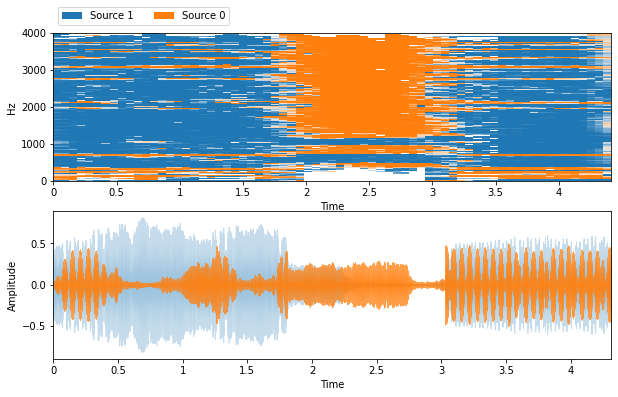


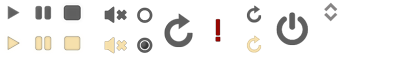
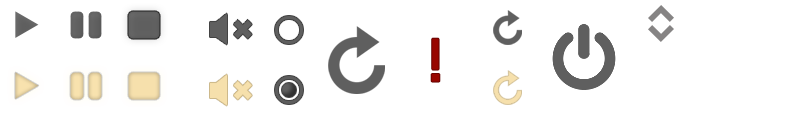
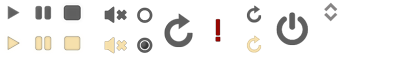

In [250]:
ibm = nussl.separation.benchmark.IdealBinaryMask(separator.audio_signal, estimates)
estimates = ibm()

estimates = {
    f'Source {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

In [231]:
estimates['Source 0'].embed_audio(display=False)

In [232]:
estimates['Source 1'].embed_audio(display=False)

In [252]:
output['audio_']

AttributeError: 'dict' object has no attribute 'shape'